Trace of the tensors shape as it is propagated through the network.
Layer name 	 Output size
----------------------------
x_pl 		 (?, 128, 64, 1)
conv1 		 (?, 128, 64, 16)
deconv	 (?, ?, ?, 1)
Model consits of  12817 trainable parameters.
Forward pass successful!
Begin training loop
Epoch 2 : Train Loss 7132.477, Valid loss 1128.786
Epoch 3 : Train Loss 5995.188, Valid loss 1030.011
Epoch 4 : Train Loss 4742.965, Valid loss 903.268
Epoch 5 : Train Loss 3845.317, Valid loss 829.477
Epoch 6 : Train Loss 3161.302, Valid loss 758.952
Epoch 7 : Train Loss 2482.288, Valid loss 693.025
Epoch 8 : Train Loss 1880.726, Valid loss 639.568
Epoch 9 : Train Loss 1442.490, Valid loss 594.148
Epoch 10 : Train Loss 1155.744, Valid loss 548.117
Epoch 11 : Train Loss 971.924, Valid loss 501.063
Epoch 12 : Train Loss 871.720, Valid loss 455.228
Epoch 13 : Train Loss 833.514, Valid loss 417.525
Epoch 14 : Train Loss 826.643, Valid loss 392.956
Epoch 15 : Train Loss 818.189, Valid loss 381.979
Epoch 16 : Tr

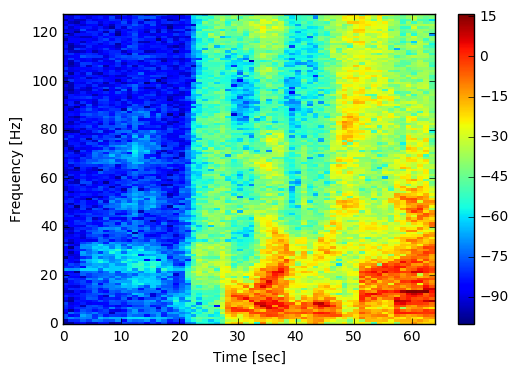

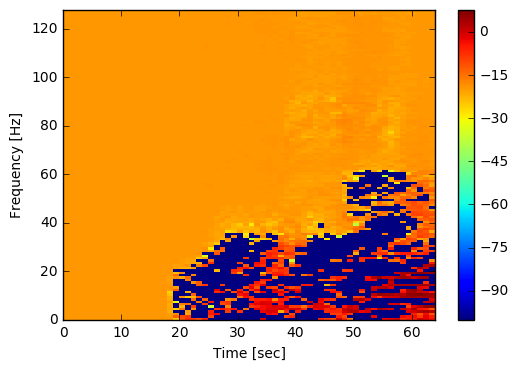

(<matplotlib.text.Text at 0x7fd29d8cca90>,
 (0.75, 1.03))

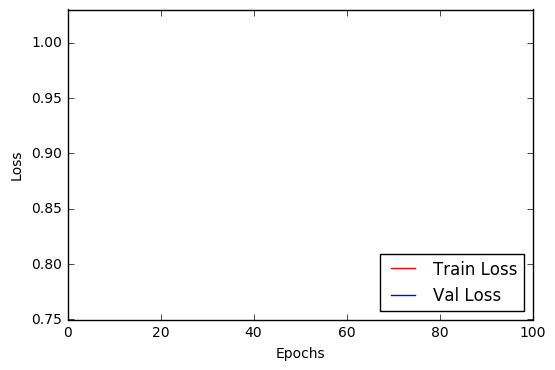

In [2]:
from __future__ import absolute_import, division, print_function

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import tensorflow as tf
import utils
from librispeech_mixer import LibriSpeechMixer
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Conv2DTranspose


tf.reset_default_graph()

height, width, nchannels = 128, 64, 1
padding = 'same'

filters_1 = 16
kernel_size_1 = (20,20)
pool_size_1 = (2,2)

x_pl = tf.placeholder(tf.float32, [None, height, width, nchannels], name='xPlaceholder')
y_pl = tf.placeholder(tf.float64, [None, height, width, nchannels], name='yPlaceholder')
y_pl = tf.cast(y_pl, tf.float32)

print('Trace of the tensors shape as it is propagated through the network.')
print('Layer name \t Output size')
print('----------------------------')

with tf.variable_scope('convLayer1'):
    conv1 = Conv2D(filters_1, kernel_size_1, strides=(1,1), padding=padding, activation='relu')
    print('x_pl \t\t', x_pl.get_shape())
    x = conv1(x_pl)
    print('conv1 \t\t', x.get_shape())

    """pool1 = MaxPooling2D(pool_size=pool_size_1, strides=None, padding=padding)
    x = pool1(x)
    print('pool1 \t\t', x.get_shape())
    x = flatten(x)
    print('Flatten \t', x.get_shape())"""



with tf.variable_scope('output_layer'):
    deconv = Conv2DTranspose(1, kernel_size_1, strides=(1,1), padding=padding, activation='relu')

    y = deconv(x)
    print('deconv\t', y.get_shape())

print('Model consits of ', utils.num_params(), 'trainable parameters.')

gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.45)

"""## Launch TensorBoard, and visualize the TF graph

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
    tmp_def = utils.rename_nodes(sess.graph_def, lambda s:"/".join(s.split('_',1)))
    utils.show_graph(tmp_def)"""


with tf.variable_scope('loss'):
    # computing cross entropy per sample
    mean_square_error = tf.reduce_sum((y_pl - y) ** 2)



with tf.variable_scope('training'):
    # defining our optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001)

    # applying the gradients
    train_op = optimizer.minimize(mean_square_error)


#Create the LibriSpeech mixer
mixer = LibriSpeechMixer()
width = mixer.spec_length
validation_mixer = LibriSpeechMixer(False)

#Test the forward pass
x_batch, y_batch = mixer.get_batch(2)

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
# with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    y_pred = sess.run(fetches=y, feed_dict={x_pl: x_batch})
    y_pred = sess.run(fetches=y, feed_dict={x_pl: x_batch})
    
    """plt.pcolormesh(10 * np.log10(x_batch[0,:,:,0]+1e-10))
    print(x_batch[0,:,:,0])
    plt.axis('tight')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()
    
    plt.pcolormesh(10 * np.log10(y_pred[0,:,:,0]+1e-10))
    print(y_pred[0,:,:,0])
    plt.axis('tight')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()"""
assert y_pred.shape == x_batch.shape, "ERROR the output shape is not as expected!"         + " Output shape should be " + str(y.shape) + ' but was ' + str(y_pred.shape)

print('Forward pass successful!')


# ## Training

#Training Loop
batch_size = 1
max_epochs = 100


valid_loss = []
train_loss = []
test_loss = []
# restricting memory usage, TensorFlow is greedy and will use all memory otherwise
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)

def trainingLoog():
    with tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts)) as sess:
        sess.run(tf.global_variables_initializer())
        print('Begin training loop')

        try:

            while mixer.epochs_completed < max_epochs:
                _train_loss = []

                ## Run train op
                x_batch, y_batch = mixer.get_batch(batch_size)
                fetches_train = [train_op, mean_square_error]
                feed_dict_train = {x_pl: x_batch, y_pl: x_batch}
                _, _loss = sess.run(fetches_train, feed_dict_train)

                _train_loss.append(_loss)

                ## Compute validation loss at the beginning of epoch
                if mixer.index_in_epoch < batch_size:
                    _valid_loss = []
                    train_loss.append(np.mean(_train_loss))

                    fetches_valid = [mean_square_error]

                    while validation_mixer.epochs_completed <= mixer.epochs_completed:
                        x_valid, y_valid = validation_mixer.get_batch(batch_size)
                        feed_dict_valid = {x_pl: x_valid, y_pl: x_valid}
                        _loss = sess.run(fetches_valid, feed_dict_valid)

                        _valid_loss.append(_loss)

                    valid_loss.append(np.mean(_valid_loss))


                    print("Epoch {} : Train Loss {:6.3f}, Valid loss {:6.3f}".format(
                        mixer.epochs_completed, train_loss[-1], valid_loss[-1]))

        
        except KeyboardInterrupt:
            pass
        
        y_pred = sess.run(fetches=x, feed_dict={x_pl: x_batch})
        
        plt.pcolormesh(10 * np.log10(x_batch[0,:,:,0]+1e-10))
        plt.axis('tight')
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        
        plt.colorbar()
        plt.show()
        
        plt.pcolormesh(10 * np.log10(y_pred[0,:,:,0]+1e-10))
        plt.axis('tight')
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        
        plt.colorbar()
        plt.show()
    
trainingLoog();


    
epoch = np.arange(len(train_loss))
plt.figure()
plt.plot(epoch, train_loss,'r', epoch, valid_loss,'b')
plt.legend(['Train Loss','Val Loss'], loc=4)
plt.xlabel('Epochs'), plt.ylabel('Loss'), plt.ylim([0.75,1.03])